In [44]:
from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.train.losses import MaximumLikelihoodLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal
import flowjax.bijections as bij
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from sklearn.preprocessing import StandardScaler
from jax import vmap
import pandas as pd
import pickle
import scipy
import jax
from flowjax.bijections import Affine, Invert
from flowjax.distributions import Transformed

In [75]:
#observed data
filename = "../simulation/observed_data/observed_stats.csv"
x_o = pd.read_csv(filename)
#simulated data round 1
filename2 = "../simulation/output/round_1/summary_stats_r1.csv"
x = pd.read_csv(filename2)
#params for simulations round 1
filename3 = "../simulation/output/round_1/thetas_r1.csv"
theta = pd.read_csv(filename3)

In [55]:
to_drop = [#correlation >0.99
    "y1_domestic",
    "y1_scot",
    "y1_captive",
    "y1_eu",
    "y1_lyb",
    "y3_domestic_captive_lyb",
    "divergence_domestic_eu",
    "y3_domestic_scot_lyb",
    "y3_domestic_eu_lyb",
    "divergence_captive_lyb",
    "segregating_sites_lyb",
    "segregating_sites_eu",
    "divergence_scot_lyb",
    "f4_domestic_scot_captive_lyb",
    "f4_domestic_captive_eu_lyb",
    "f4_domestic_scot_eu_lyb",
    "diversity_domestic",
    "y3_domestic_scot_captive",
    "y3_scot_captive_eu",
    "f2_domestic_eu",
    "y2_domestic_lyb",
    "y3_scot_captive_lyb",
    "divergence_captive_eu",
    "pc1_dist_domestic_eu",
    # outlier noise model method r1 (>1)
    'tajimas_d_eu',
    'relatedness_domestic_lyb',
    'pc1_iqr_domestic',
    'pc1_iqr_eu',
    'pc1_iqr_lyb',
    'pc2_iqr_domestic',
    'pc2_iqr_lyb',
    # outlier noise model method r2 (>0.8)
    'relatedness_captive_lyb',
    'pc1_median_eu',
    'pc2_dist_domestic_lyb',
    # drop_one algorithm, achieved 0.7788 hdr
    'pc2_iqr_eu',
    'relatedness_domestic_eu',
    'tajimas_d_lyb',
    'pc1_dist_captive_eu',
    'fst_scot_lyb',
    'pc2_iqr_scot',
    'pc1_dist_scot_lyb',
    'pc1_dist_eu_lyb']

In [56]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(10001, 93)

In [57]:
theta = theta.to_numpy(dtype=np.float32)
theta = jnp.log(theta)

In [58]:
## new standardisation for target (theta)
preprocess = Affine(-theta.mean(axis=0)/theta.std(axis=0), 1/theta.std(axis=0))

theta_t = jax.vmap(preprocess.transform)(theta)

In [59]:
#normalise data
x_scaler = StandardScaler()
print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:10000])
x_o_t = np.float32(combined_x_t[10000])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 93)
x_t shape (10000, 93)
x_o_t shape (1, 93)


In [36]:
import statistics
statistics.mean(x_t[:,1])

2.4855865e-07

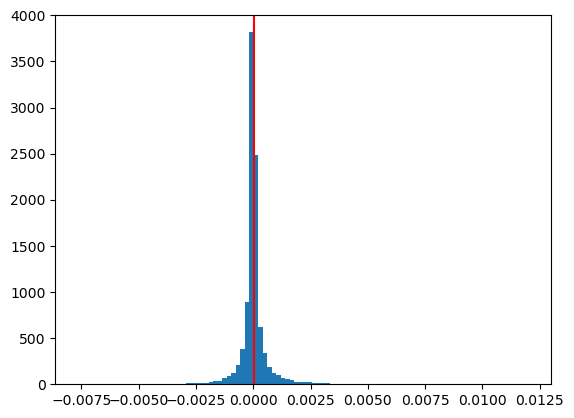

In [53]:
plt.hist(combined_x[:,50], bins=100)
plt.axvline(x=4.49e-5, color='r')

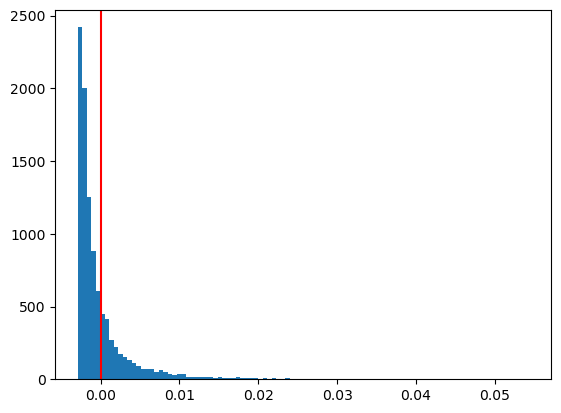

In [37]:
plt.hist(x_t[:,3], bins=100)
plt.axvline(x=4.49e-5, color='r')

In [93]:
theta = theta.to_numpy(dtype=np.float32)
theta = theta[1:10001]
log_theta = jnp.log(theta)
theta_scaler = StandardScaler()
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

theta_t shape (20000, 16)


In [8]:
# save scaler models
with open('./sequential_files/x_scaler.pkl','wb') as f:
    pickle.dump(x_scaler, f)
    
with open('./sequential_files/theta_scaler.pkl','wb') as f:
    pickle.dump(theta_scaler, f)

In [102]:
with open('./sequential_files/x_scaler.pkl','rb') as f:
    x_scaler = pickle.load(f)

print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:10000])
x_o_t = np.float32(combined_x_t[10000])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 93)
x_t shape (10000, 93)
x_o_t shape (1, 93)


In [103]:
with open('./sequential_files/theta_scaler.pkl','rb') as f:
    theta_scaler = pickle.load(f)


theta = theta.to_numpy(dtype=np.float32)
theta = theta[1:10001]
log_theta = jnp.log(theta)
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

theta_t shape (10000, 16)


In [60]:
key, subkey = jr.split(jr.PRNGKey(2))
#define prior
unbounded_prior = Normal(jnp.zeros(16))

In [61]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(16)),
    transformer=bij.Affine(),
    cond_dim=x_o_t.size,
)

In [106]:
#for sequential:
flow = eqx.tree_deserialise_leaves("./sequential_files/posterior_r1_ml.eqx", flow)

In [62]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
    )

In [63]:
#for first round
loss_fn = MaximumLikelihoodLoss()

In [108]:
loss_fn = ContrastiveLoss(unbounded_prior, n_contrastive=10)

In [64]:
fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    loss_fn=loss_fn,
    x=theta_t,
    condition=x_t,
    max_epochs=1000,
    optimizer=optimizer,
    max_patience=20
)

 18%|█▊        | 184/1000 [00:44<03:16,  4.15it/s, train=4.9576035, val=8.822939 (Max patience reached)]


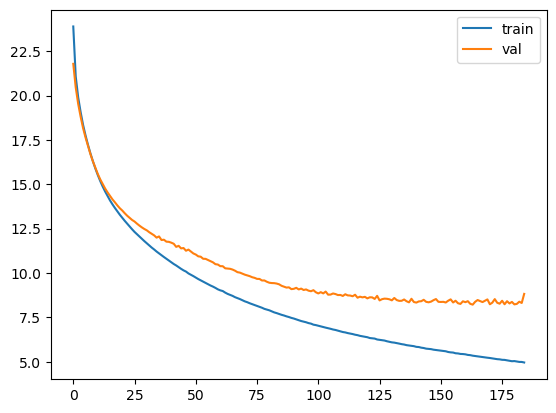

In [66]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()
#plt.axis([0, 300, -30, 5])
plt.savefig("./sequential_files/losses_r1_new_transformation.png")

In [67]:
# save proposal between rounds
model = fitted_flow

eqx.tree_serialise_leaves("./sequential_files/posterior_r1_ml_new_trans.eqx", model)

In [70]:
# save sample parameters for next round
posterior = Transformed(fitted_flow, Invert(preprocess))

samples = posterior.sample(subkey, (10000,), condition=x_o_t)
print(np.shape(samples))
samples = np.reshape(samples, (10000,16))

(10000, 1, 16)


In [72]:
samples

Array([[  2.7560015,  11.348146 ,   7.902836 , ...,  10.345502 ,
        -18.199764 , -17.70255  ],
       [  3.0328314,  11.015943 ,   8.594672 , ...,  10.232305 ,
        -17.89005  , -18.14608  ],
       [  2.9344335,  11.162037 ,   8.304138 , ...,  10.256621 ,
        -17.972769 , -18.251148 ],
       ...,
       [  3.2394292,  11.313208 ,   8.349409 , ...,  10.53411  ,
        -18.281559 , -18.154968 ],
       [  3.8418949,  11.474033 ,   8.356232 , ...,  10.648048 ,
        -18.424625 , -18.518297 ],
       [  2.6614146,  11.865923 ,   7.6325297, ...,  11.008377 ,
        -18.799541 , -18.13257  ]], dtype=float32)

In [74]:
theta_2 = np.exp(samples)

In [48]:
samples = theta_scaler.inverse_transform(samples)
theta_3 = np.exp(samples)

In [40]:
np.shape(theta_3)
tr3 = pd.DataFrame(theta_3)
tr3.to_csv("./sequential_files/tr3_ml.csv", index=False)

In [52]:
np.unique(theta_3)

array([nan], dtype=float32)

In [42]:
#theta_3 = pd.read_csv("./previous/thetas_r3.csv")
#theta_3 = theta_3.to_numpy(dtype=np.float32)
theta_2 = pd.read_csv("../simulation/output/round_2/thetas_r2.csv")
theta_2 = theta_2.to_numpy(dtype=np.float32)
theta = pd.read_csv("../simulation/output/round_1/thetas_r1.csv")
theta = theta.to_numpy(dtype=np.float32)
np.shape(theta_2)

(9900, 16)

In [82]:
priors_dict = {
    "captive_time": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "div_time": scipy.stats.lognorm(s=0.7, loc=10000, scale=60000),
    "div_time_dom": scipy.stats.lognorm(s=0.5, loc=500, scale=3000),
    "div_time_scot": scipy.stats.lognorm(s=0.3, loc=0, scale=3000),
    "mig_rate_captive": scipy.stats.lognorm(s=1, loc=0, scale=0.07),
    "mig_rate_scot": scipy.stats.lognorm(s=1, loc=0, scale=0.07),
    "mig_length_scot": scipy.stats.lognorm(s=0.7, loc=0, scale=np.exp(3)),
    "pop_size_captive": scipy.stats.lognorm(s=0.6, loc=0, scale=100),
    "pop_size_domestic_1": scipy.stats.lognorm(s=1, loc=0, scale=60000),
    "pop_size_lyb_1": scipy.stats.lognorm(s=1, loc=0, scale=20000),
    "pop_size_lyb_2": scipy.stats.lognorm(s=1.5, loc=5000, scale=100000),
    "pop_size_scot_1": scipy.stats.lognorm(s=1, loc=0, scale=4000),
    "pop_size_eu_1": scipy.stats.lognorm(s=1.3, loc=0, scale=20000),
    "pop_size_eu_2": scipy.stats.lognorm(s=1, loc=0, scale=60000),
    "mutation_rate": scipy.stats.lognorm(s=1, loc=0, scale=1e-8),
    "recombination_rate": scipy.stats.lognorm(s=0.5, loc=0.4e-8, scale=9e-9)
}

theta = []
for key, prior in priors_dict.items():
    theta.append(prior.rvs(10000))
theta = np.concatenate(theta, axis=0)
print(np.shape(theta))
theta = np.reshape(theta, (16,10000))
print(np.shape(theta))

(160000,)
(16, 10000)


In [77]:
params = {
    "captive_time": {"bins" : np.arange(0, 100, 1), "lims" : [0, 100]},
    "div_time": {"bins" : np.arange(0, 400000, 3000), "lims" : [0, 400000]},
    "div_time_dom": {"bins" : np.arange(500, 11000, 100), "lims" : [500, 11000]},
    "div_time_scot": {"bins" : np.arange(1000, 7000, 50), "lims" : [1000, 7000]},
    "mig_rate_captive": {"bins" : np.arange(0, 0.4, 0.005), "lims" : [0, 0.4]},
    "mig_rate_scot": {"bins" : np.arange(0, 0.3, 0.004), "lims" : [0, 0.3]},
    "mig_length_scot": {"bins" : np.arange(0, 80, 1), "lims" : [0, 80]},
    "pop_size_captive": {"bins" : np.arange(0, 500, 5), "lims" : [0, 500]},
    "pop_size_domestic_1": {"bins" : np.arange(0, 500000, 4000), "lims" : [0, 500000]},
    "pop_size_lyb_1": {"bins" : np.arange(0, 100000, 800), "lims" : [0, 100000]},
    "pop_size_lyb_2": {"bins" : np.arange(0, 750000, 5000), "lims" : [0, 750000]},
    "pop_size_scot_1": {"bins" : np.arange(0, 30000, 200), "lims" : [0, 30000]},
    "pop_size_eu_1": {"bins" : np.arange(0, 150000, 2000), "lims" : [0, 150000]},
    "pop_size_eu_2": {"bins" : np.arange(0, 250000, 2500), "lims" : [0, 250000]},
    "mutation_rate": {"bins" : np.arange(0, 0.6e-7, 0.6e-9), "lims" : [0, 0.6e-7]},
    "recombination_rate": {"bins" : np.arange(0.5e-8, 3.5e-8, 3e-10), "lims" : [0.5e-8, 3.5e-8]}
         }

names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

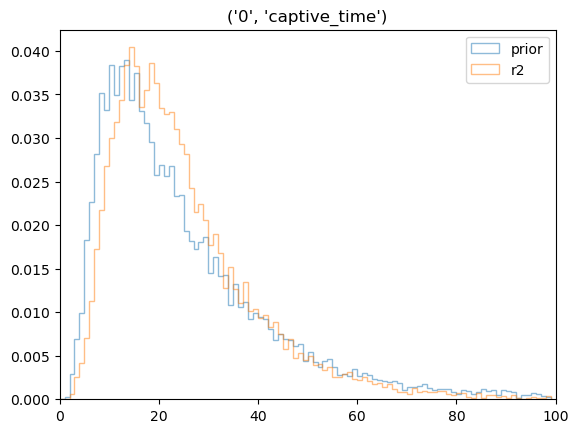

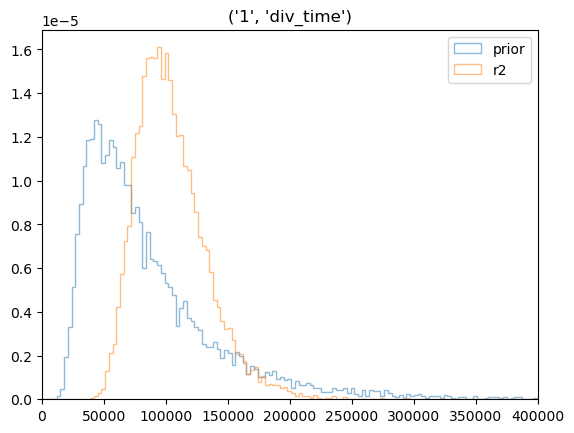

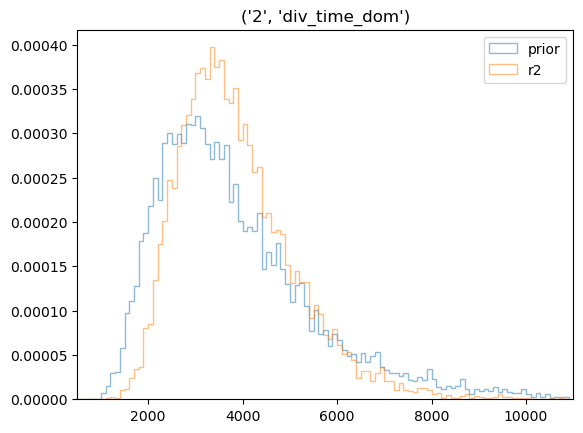

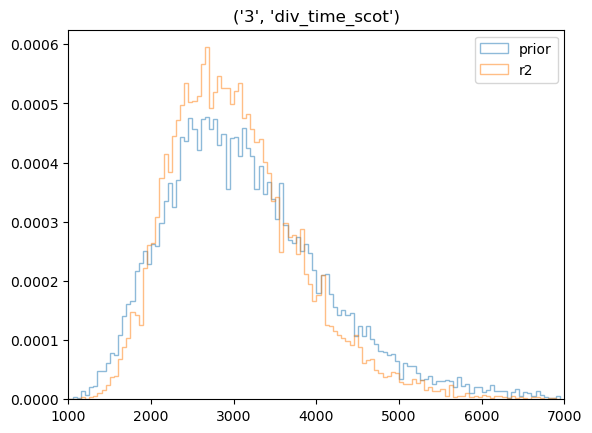

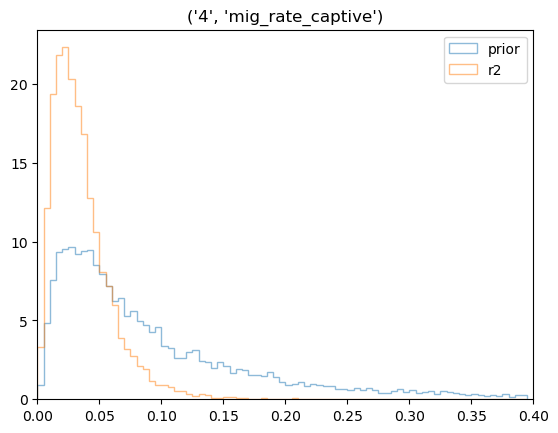

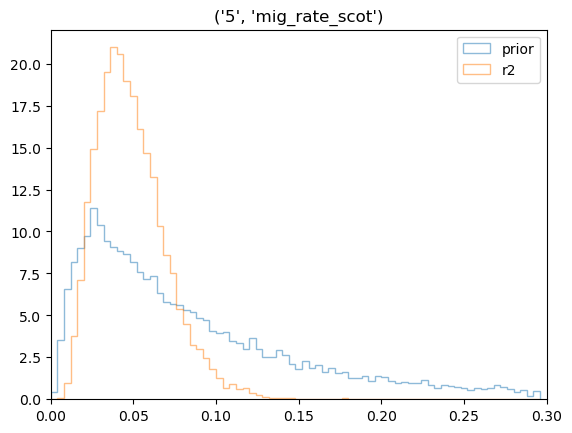

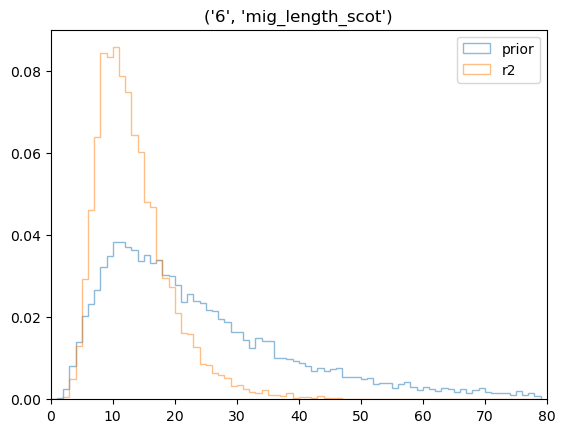

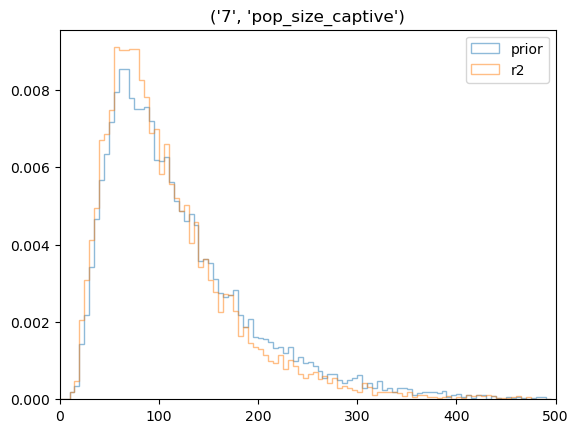

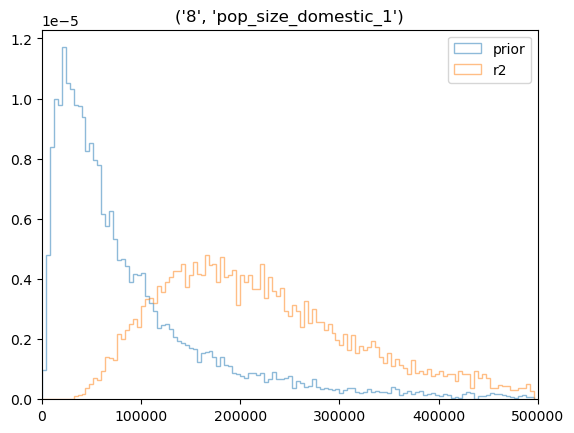

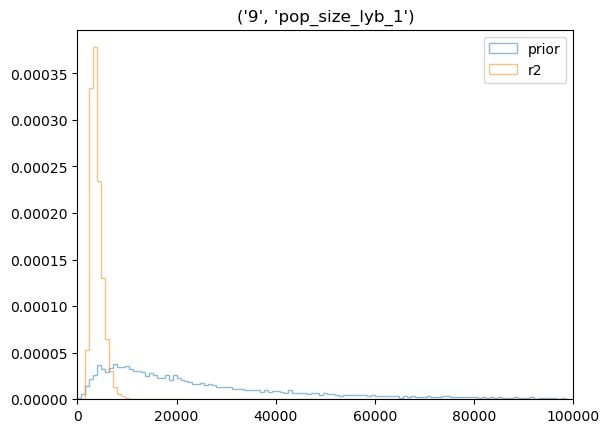

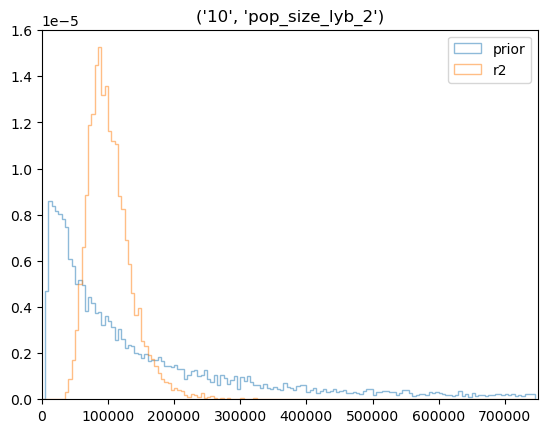

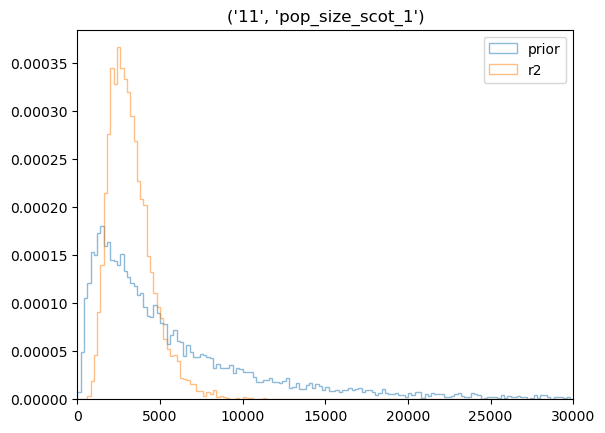

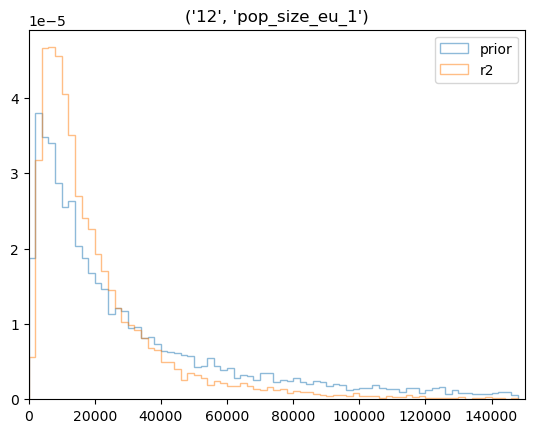

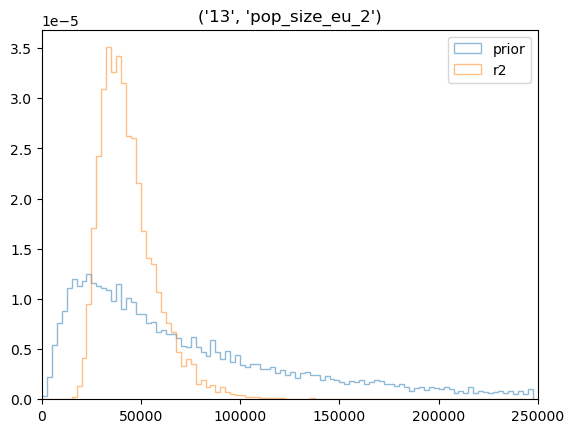

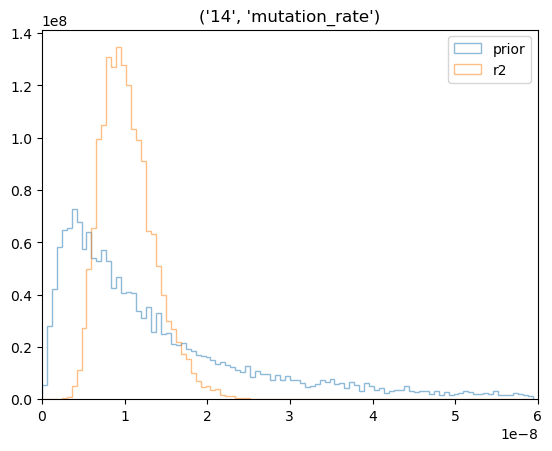

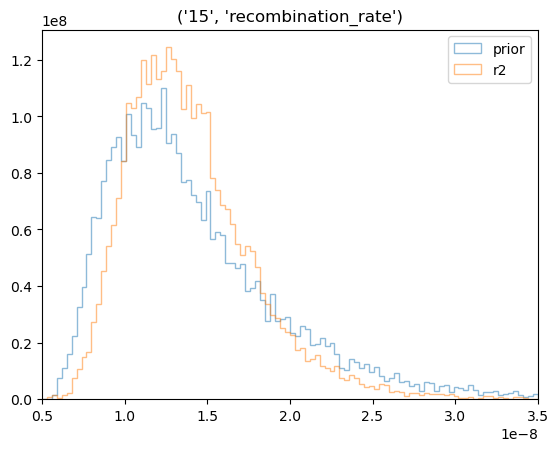

In [83]:
# plot parameter distributions
for num in range(0,16): 
    stat = names[num]
    
    plt.hist(theta[num][:],
             alpha=0.5,
             label='prior', bins=params[stat]["bins"], density=True, histtype='step')
    
    plt.hist(theta_2[:,num],
             alpha=0.5,
             label='r2', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_3[:,num],
        #     alpha=0.5,
        #     label='r3', bins=params[stat]["bins"], density=True, histtype='step')

    #plt.hist(theta_4[:,num],
         #    alpha=0.5,
         #    label='r4', bins=params[stat]["bins"], density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(label=(str(num), stat))
    #plt.yticks([])
    plt.xlim(params[stat]["lims"])
    plt.show()